In [1]:
import sys
sys.path.insert(0, "/home/jogi/git/repository/meta_learner")
if "/home/jogi/.local/lib/python2.7/site-packages" in sys.path:
    sys.path.remove("/home/jogi/.local/lib/python2.7/site-packages")

import matplotlib
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

from datetime import datetime
from pytz import timezone
import itertools
import copy

import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
from collections import OrderedDict


from utils.experiment import Experiment
from utils.common import get_model, create_def_argparser, create_logger, softmax
from utils.plots import loss_plot, param_error_plot, plot_qt_probs, plot_dist_optimization_steps
from utils.plots import plot_actsb_qts, plot_image_map_data, plot_image_map_losses
from utils.plots import plot_loss_over_tsteps, plot_halting_step_stats_with_loss
from utils.probs import TimeStepsDist, ConditionalTimeStepDist
from utils.config import config
from val_optimizer import validate_optimizer
from utils.regression import RegressionFunction, L2LQuadratic, RegressionWithStudentT
from utils.helper import tensor_and, tensor_any
from utils.batch_handler import ACTBatchHandler
from utils.epoch import Epoch, halting_step_stats
from models.rnn_optimizer import MetaLearner, AdaptiveMetaLearnerV1, AdaptiveMetaLearnerV2
from models.sb_act_optimizer import StickBreakingACTBaseModel

from utils.regression import RegressionFunction, L2LQuadratic, neg_log_likelihood_loss, RosenBrock
from utils.regression import RegressionWithStudentT

%load_ext autoreload
%autoreload 2

In [2]:
expers_to_load = [# Meta V1 model regressionT
                  (True, "run_20170814_11_47_03_metaV1_50ep_50ops_lr3e05"), # 50ops
                  (False, "run_20170814_17_04_25_metaV1_50ep_100ops_lr3e05"), # 100ops
                  (False, "run_20170814_12_03_15_metaV2_50ep_26ops_lr3e05"), # stochastic 26 ops
                  # Stick-breaking V1 model
                  (False, "run_20170724_22_55_12_actV2_70ep_32ops_lr5e05_adam"), # nu=0.1
                  (False, "run_20170811_15_54_49_act_sbV1_45ep_nu0.2_lr5e05"), # nu=0.2
                  (False, "run_20170814_14_05_22_act_sbV1_50ep_nu0.3_lr5e05"), # nu=0.3
                  (False, "run_20170724_17_46_16_actV2_70ep_32ops_lr5e05_adam"), # nu=0.6
                  (False, "run_20170814_14_27_22_act_sbV1_50ep_nu0.7_lr5e05"), # nu=0.7
                  (False, "run_20170814_15_32_34_act_sbV1_50ep_nu0.7_lr5e05"), # nu=0.7 with 20 KL steps annealing
                  (False, "run_20170814_16_06_50_act_sbV1_50ep_nu0.7_lr5e05"), # nu=0.7 with 45 KL steps annealing
                  (False, "run_20170814_12_41_13_act_sbV1_50ep_nu0.9_lr5e05"), # 0.9
                  (True, "run_20170814_19_02_30_act_sbV1_50ep_nu0.9_lr5e05"), # 0.9 with 50steps annealing
                  (False, "run_20170814_11_13_42_act_sbV1_50ep_nu0.95_lr5e05"), # nu=0.95
                  # Stick-breaking V3 model with neg-binomial
                  (True, "run_20170815_10_22_49_act_sbV3_50ep_nu0.5_lr5e05")] # nu=0.5 n=50


In [3]:
without_models = False

experiments = []
models = []
new_experiments = []
explogger = None
m = 0
if 'logger' in vars() or 'logger' in globals():
    pass
else:
    logger = create_logger(exper=None, file_handler=True, output_dir="/home/jogi/git/repository/meta_learner/logs")

for e, exp_path in enumerate(expers_to_load):
    if exp_path[0]:
        
        exp = Experiment.load(exp_path[1], do_log=True, meta_logger=logger)
            
        if "act" in exp.args.model:
            print("{} Loading model {} (q-prob {:.2f}) / {}".format(m, exp.args.model, 
                                                                    exp.config.ptT_shape_param,
                                                                    exp.args.log_dir))
        else:
            print("{} Loading model {} / {}".format(m, exp.args.model, exp.args.log_dir))
        
        experiments.append(exp)
        m += 1
        if not without_models:
            models.append(get_model(exp, exp.args.x_dim, retrain=True))
        new_experiments.append(Experiment(exp.args, exp.config))
        new_experiments[-1].output_dir = experiments[-1].output_dir
        new_experiments[-1].reset_val_stats()
        new_experiments[-1].meta_logger = logger


INFO - created local logger for experiment with model metaV1_regression_T_50ops
INFO - INFO - loaded existing model from file logs/run_20170814_11_47_03_metaV1_50ep_50ops_lr3e05/metaV1_regression_T_50ops.pkl
INFO - Note: MetaLearner is running on GPU
INFO - ['linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_out.weight']
INFO - created local logger for experiment with model act_sbV1_regression_T_nu0.9
INFO - INFO - loaded existing model from file logs/run_20170814_19_02_30_act_sbV1_50ep_nu0.9_lr5e05/act_sbV1_regression_T_nu0.9.pkl
INFO - Note: StickBreakingACTBaseModel is running on GPU
INFO - ['linear_in.weight', 'linear_in.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1

0 Loading model metaV1_regression_T_50ops / run_20170814_11_47_03_metaV1_50ep_50ops_lr3e05
1 Loading model act_sbV1_regression_T_nu0.9 (q-prob 0.90) / run_20170814_19_02_30_act_sbV1_50ep_nu0.9_lr5e05
2 Loading model act_sbV3_regression_T_nu0.5 (q-prob 0.50) / run_20170815_10_22_49_act_sbV3_50ep_nu0.5_lr5e05


In [7]:
del new_experiments
new_experiments = []
max_eval_steps = 200

for exper in expers_to_load:
    if exper[0]:
        new_experiments.append(Experiment.load(path_to_exp=exper[1] + "/" + 
                                               "exp_eval_stats_10000_" + str(max_eval_steps) +"steps.dll",
                                               full_path=True))
print("Ready")

Ready


In [4]:
with open("data/test_regression_T_10000_10_1.0_10.dll", 'rb') as f:
     test_funcs = dill.load(f)
print("Ready")

Ready


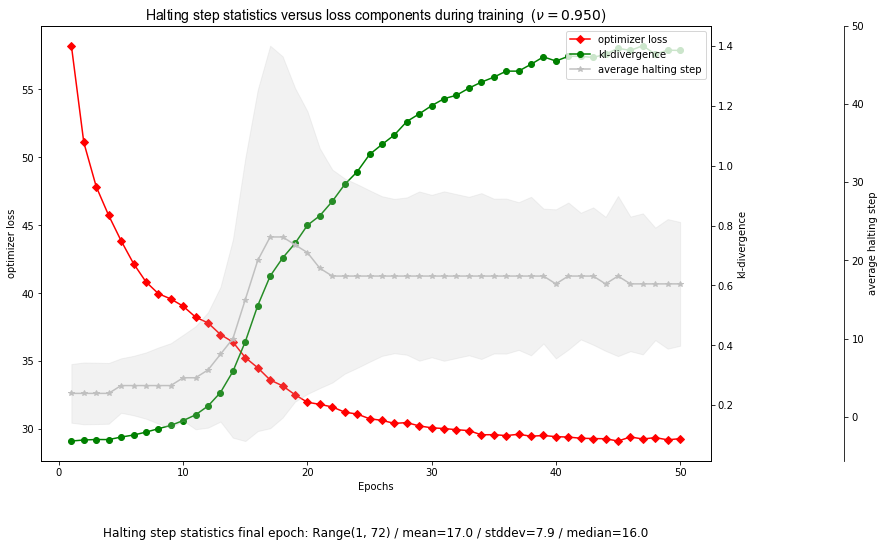

In [13]:
plot_halting_step_stats_with_loss(experiments[2], do_show=True, do_save=False, add_info=True)

INFO - Successfully saved fig figures/10regT_actsb_compareV1V2V3.png


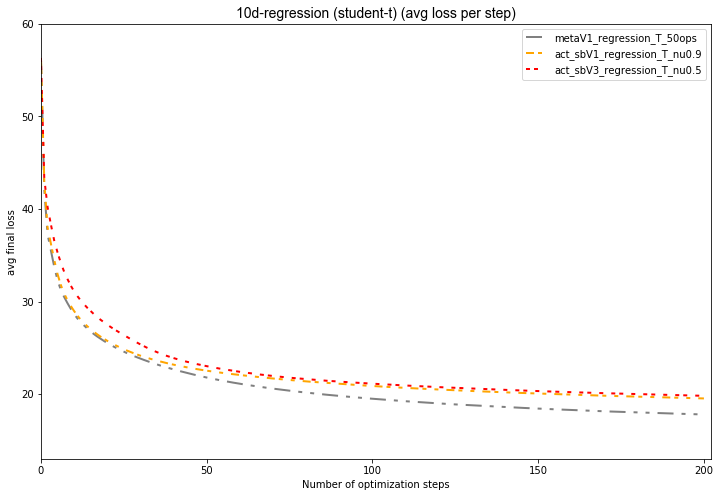

In [10]:
# new_exp_select = [new_experiments[0], new_experiments[1], new_experiments[3], new_experiments[4]] 
best_val_runs, lowest_value = plot_loss_over_tsteps(new_experiments, do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              fig_name="10regT_actsb_compareV1V2V3", 
                                              loss_type="loss",
                                              min_step=0,
                                              max_step=200,
                                              sort_exper="10d-regression (student-t)",
                                              log_scale=False,
                                              with_stddev=False,
                                              runID=None)

INFO - Successfully saved fig logs/run_20170814_19_02_30_act_sbV1_50ep_nu0.9_lr5e05/loss_optimizer_act_sbV1_50ep_nu0.9_08:58:01.png


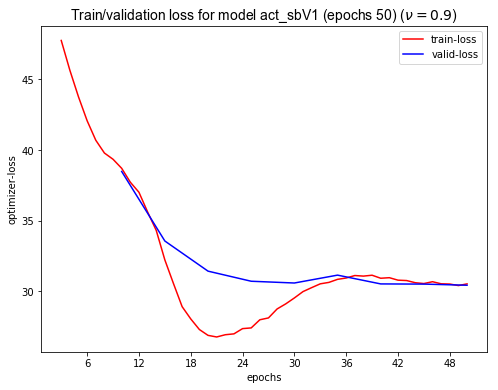

In [5]:
loss_plot(experiments[1], loss_type="opt_loss", save=True, show=True, 
          log_scale=False, validation=True, only_val=False)

In [ ]:
# exp_error_curves = [experiments[0],  experiments[3]]
for exp, mdl in zip(experiments, models):
    print(mdl.name)
    loss_plot(exp, loss_type="loss", save=False, validation=True, show=True)


In [ ]:
# eval_new_val_expers = [new_experiments[0], new_experiments[3]] #, new_experiments[5]]

best_val_runs, lowest_value = plot_val_result(new_experiments, 
                                              do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              loss_type="loss",
                                              fig_name="expv5_val_results_1000_loss_10ops")

In [ ]:
# eval_expers = new_exp_only = [experiments[0], experiments[1], experiments[2]]
plot_parm_loss_steps(experiments, num_of_plots=4, do_show=True, 
                     do_save=False, loss_type="loss", log_scale=False, max_step=20,
                    fig_name="metaV2_val_loss_during_training")

In [6]:
exp_idx = 2
model = models[exp_idx]

max_steps = 200
# new_experiments[exp_idx].model_path

new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
new_experiments[exp_idx].type_prior = "neg-binomial"

epoch_obj = Epoch()
epoch_obj.start(new_experiments[exp_idx])
print("Validating model {} with q-prob {:.3f}".format(model.name, experiments[exp_idx].config.ptT_shape_param))
new_experiments[exp_idx].eval(epoch_obj, model, functions=test_funcs, save_run=None, save_model=False)
print("End....")
new_experiments[exp_idx].save("exp_eval_stats_10000_"+str(max_steps) + "steps.dll")

INFO - Epoch: 400 - Evaluating 10000 test functions


Validating model act_sbV3_regression_T_nu0.5 with q-prob 0.500


INFO - ! - Validation last step 115 - !
INFO - Epoch: 400 - evaluation result - time step losses
INFO - [ 56.32   43.302  40.21   38.324  36.594  35.304  34.176  33.212  32.428
  31.714  31.093  30.58   30.112  29.702  29.313  28.963  28.625  28.319
  28.022  27.753  27.492  27.25   27.017  26.799  26.584  26.37   26.162
  25.955  25.751  25.553  25.363  25.177  25.003  24.836  24.675  24.525
  24.381  24.246  24.119  24.     23.888  23.78   23.677  23.581  23.489
  23.402  23.317  23.237  23.158  23.084  23.012  22.942  22.873  22.808
  22.743  22.684  22.623  22.565  22.509  22.454  22.4    22.351  22.299
  22.25   22.206  22.157  22.113  22.071  22.028  21.987  21.947  21.911
  21.874  21.836  21.802  21.766  21.735  21.704  21.671  21.64   21.61
  21.581  21.552  21.527  21.494  21.471  21.442  21.417  21.393  21.366
  21.343  21.318  21.295  21.273  21.248  21.225  21.202  21.18   21.161
  21.14   21.117  21.099  21.078  21.057  21.038  21.017  20.999  20.978
  20.962  20.944  20.

End....


In [9]:
X = np.vstack(new_experiments[2].val_stats["halt_step_funcs"].values())

In [25]:
print(len(new_experiments))
exp_idx = 0
max_steps = 200
new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
new_experiments[exp_idx].config.qt_threshold = 0.95
new_experiments[exp_idx].reset_val_stats()
if new_experiments[exp_idx].meta_logger is None:
    new_experiments[exp_idx].meta_logger = logger
# the same object for the validation data
model = models[exp_idx]
model.opt_step_hist_val = np.zeros(new_experiments[exp_idx].config.max_val_opt_steps)
model.qt_hist_val = OrderedDict([(i, np.zeros(i)) 
                                 for i in np.arange(1, new_experiments[exp_idx].config.max_val_opt_steps + 1)])
print("Validating model {} with q-prob {:.3f}".format(model.name, experiments[exp_idx].config.ptT_shape_param))

if "act" in model.name:
    model.init_qt_statistics(new_experiments[exp_idx].config)

validate_optimizer(model, new_experiments[exp_idx], explogger, val_set=test_funcs, 
                   max_steps=max_steps, verbose=False, plot_func=False, show_plot=False, save_plot=False,
                   num_of_plots=5, save_model=False, save_qt_prob_funcs=False, 
                   save_run="exp_eval_stats_10000_"+str(max_steps) + "steps")
new_experiments[exp_idx].save("exp_eval_stats_10000_"+str(max_steps) + "steps.dll")

INFO - ---------------------------------------------------------------------------------------
INFO - INFO - Epoch 400: Validating model metaV1_regression_T_100ops with 10000 functions


2
Validating model metaV1_regression_T_100ops with q-prob 0.700


INFO - INFO - Epoch 400, elapsed time 8.01 seconds: 
INFO - INFO - Epoch 400: Final validation stats: total-step-losses / final-step loss / final-true_min: 4.186e+03/17.52/6.071
INFO - INFO - Epoch 400: Final step losses: [ 56.32   42.035  37.149  35.412  33.734  32.236  31.204  30.455  29.769
  29.127  28.584  28.13   27.726  27.356  27.018  26.709  26.422  26.15
  25.895  25.656  25.431  25.219  25.018  24.826  24.642  24.463  24.294
  24.135  23.982  23.841  23.701  23.567  23.438  23.312  23.191  23.073
  22.958  22.845  22.735  22.628  22.526  22.427  22.328  22.234  22.146
  22.056  21.971  21.89   21.809  21.73   21.653  21.577  21.503  21.433
  21.366  21.298  21.231  21.163  21.099  21.036  20.976  20.916  20.858
  20.801  20.745  20.689  20.636  20.585  20.534  20.484  20.434  20.385
  20.338  20.292  20.248  20.207  20.163  20.122  20.079  20.038  19.998
  19.959  19.92   19.881  19.843  19.806  19.768  19.733  19.698  19.662
  19.627  19.591  19.557  19.522  19.49   19.46  

In [ ]:
plot_qt_probs(new_experiments[2], data_set="val", save=True, show=True, 
              plot_prior=False, height=20, width=20, add_info=True)

In [ ]:
from utils.plots import create_exper_label
num_of_plots = 13
T0 = 23
fig = plt.figure(figsize=(8, 25))

for i in range(1, num_of_plots+1):
    T = T0+i
    index = np.arange(1, T+1).astype(int)
    qt = exper.val_stats["qt_hist"][30][T]
    ax1 = plt.subplot(num_of_plots, 1, i)
    plt.bar(index, qt, 0.3, label="q(t|{})".format(T))
    ax1.legend(loc="best")
    
fig_name = "_" + "val" + "_" + create_exper_label(exper)
fig_name = os.path.join(exper.output_dir, config.qt_dist_prefix + fig_name + ".png")
plt.savefig(fig_name, bbox_inches='tight')
plt.close()

INFO - Successfully saved fig logs/run_20170814_17_04_25_metaV1_50ep_100ops_lr3e05/loss_metaV1_50ep_100ops_21:43:29.png


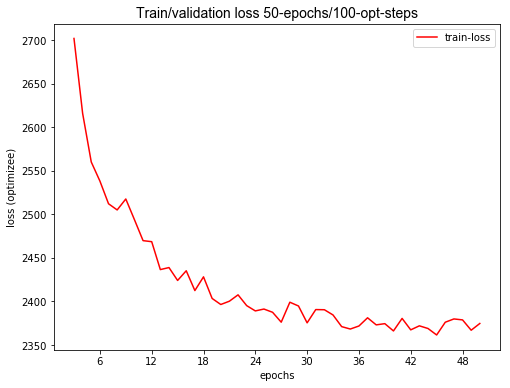

In [41]:
loss_plot(experiments[0], show=True, save=True, validation=False, only_val=False)

INFO - Successfully saved fig logs/run_20170814_19_02_30_act_sbV1_50ep_nu0.9_lr5e05/qt_dist_using_model_from_epoch50.png


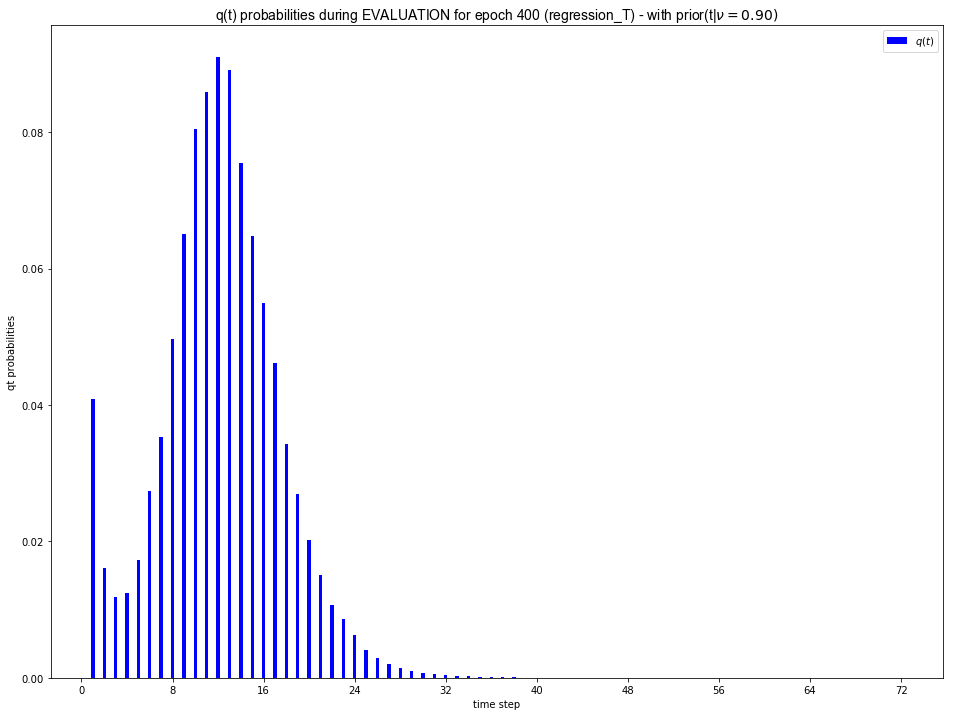

In [30]:
plot_actsb_qts(new_experiments[1], data_set="eval", save=True, show=True, add_info=False, epoch=400, 
              fig_name="qt_dist_using_model_from_epoch50")

In [ ]:
def compute_yt(W, x):
    return torch.transpose(torch.mm(W ,x.unsqueeze(1)), 1,0)

def compute_params(W, y, cuda=False):
    
    A_plus = np.linalg.pinv(W.data.cpu().numpy())
    y = y.data.cpu().numpy()
    params = np.squeeze(np.dot(A_plus, y))
    params = Variable(torch.from_numpy(params).float().unsqueeze(0))
    if cuda:
        params = params.cuda()
    return params
    


In [ ]:
plot_qt_detailed_stats(new_experiments[0], test_funcs, do_save=True, do_show=True, threshold=0.90)

In [ ]:
 # 
plot_kl_div_parts(new_experiments[1], save=False, show=True, final_terms=False, log_qt=True, plot_prior=True,
                 fig_name="kl_parts_without_tanh")

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')

s = 0.05   # Try s=1, 0.25, 0.1, or 0.05
X = np.arange(-1.2, 4+s, s)   #Could use linspace instead if dividing
Y = np.arange(10, 13+s, s)   #evenly instead of stepping...
    
#Create the mesh grid(s) for all X/Y combos.
X, Y = np.meshgrid(X, Y)

#Rosenbrock function w/ two parameters using numpy Arrays
Z = (3.5-X)**2 + 100.*(Y-X*X)**2

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
         linewidth=0, antialiased=False)  #Try coolwarm vs jet

plt.xlabel('x')
plt.ylabel('y')
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

#Displays the figure, handles user interface, returns when user closes window
plt.show()

In [5]:
"""
    Generate new test functions
"""
test_funcs = RegressionWithStudentT(n_funcs=10000, n_samples=10, x_dim=10, scale_p=1., shape_p=1, use_cuda=True)
with open("data/test_regression_T_10000_10_1.0_10.dll", 'wb') as f:
     dill.dump(test_funcs, f)
print("Ready")


Ready


In [31]:
experiments[1].generate_figures()

INFO - Successfully saved fig logs/run_20170814_19_02_30_act_sbV1_50ep_nu0.9_lr5e05/loss_act_sbV1_50ep_nu0.9_09:34:56.png
INFO - Successfully saved fig logs/run_20170814_19_02_30_act_sbV1_50ep_nu0.9_lr5e05/loss_optimizer_act_sbV1_50ep_nu0.9_09:34:56.png
INFO - Successfully saved fig logs/run_20170814_19_02_30_act_sbV1_50ep_nu0.9_lr5e05/train_step_loss_map_act_sbV1_50ep_nu0.9.png
INFO - Successfully saved fig logs/run_20170814_19_02_30_act_sbV1_50ep_nu0.9_lr5e05/T_dist_train.png
INFO - Successfully saved fig logs/run_20170814_19_02_30_act_sbV1_50ep_nu0.9_lr5e05/eval_step_loss_map_act_sbV1_50ep_nu0.9.png
INFO - Successfully saved fig logs/run_20170814_19_02_30_act_sbV1_50ep_nu0.9_lr5e05/train_step_map_qts_act_sbV1_50ep_nu0.9.png
INFO - Successfully saved fig logs/run_20170814_19_02_30_act_sbV1_50ep_nu0.9_lr5e05/train_step_map_halting_act_sbV1_50ep_nu0.9.png
INFO - Successfully saved fig logs/run_20170814_19_02_30_act_sbV1_50ep_nu0.9_lr5e05/qt_values_train_act_sbV1_50ep_nu0.9.png
INFO - S